<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_04_pytorch_sklearn_pipeline_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load and Preprocess the Dataset

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load the Credit Card Default dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Print unique values of the target variable in the original dataset
print("Unique values in the original target variable:", df['default_payment_next_month'].unique())

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target] + ['id'])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns (if any)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


Unique values in the original target variable: [1 0]


### Create a Baseline Neural Network Model

Epoch 10/50, Training Loss: 0.4461, Validation Loss: 0.4378
Epoch 20/50, Training Loss: 0.4420, Validation Loss: 0.4328
Epoch 30/50, Training Loss: 0.4386, Validation Loss: 0.4323
Epoch 40/50, Training Loss: 0.4366, Validation Loss: 0.4318
Epoch 50/50, Training Loss: 0.4342, Validation Loss: 0.4318


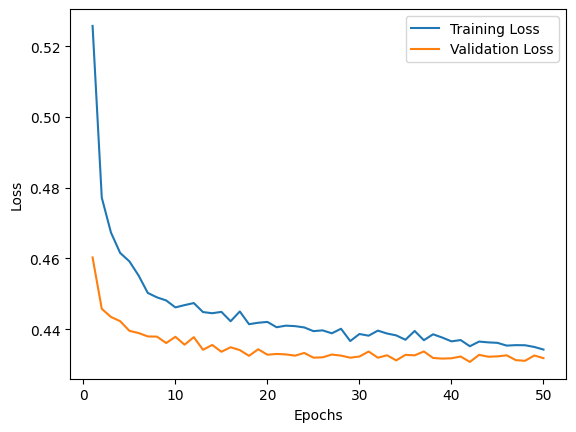

Test Loss: 0.4318
              precision    recall  f1-score   support

         0.0       0.84      0.96      0.89      4687
         1.0       0.68      0.33      0.44      1313

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.67      6000
weighted avg       0.80      0.82      0.79      6000



In [3]:
# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Train the model
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

# Plot learning curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predictions = (test_outputs > 0.5).float()
    print(f'Test Loss: {test_loss.item():.4f}')
    print(classification_report(y_test_tensor.numpy(), test_predictions.numpy()))


## Incremental Improvements

1. **Add Dropout**: We already added dropout layers in the `SimpleNN` class.
2. **Use Weight Decay**: Weight decay is already applied in the optimizer.
3. **Early Stopping**: Implement early stopping to prevent overfitting.
4. **Hyperparameter Tuning**: Experiment with different architectures, learning rates, and batch sizes.
5. **Cross-Validation**: Use cross-validation to better estimate model performance.

Validation loss did not improve, trigger times: 1
Validation loss did not improve, trigger times: 1
Validation loss did not improve, trigger times: 2
Validation loss did not improve, trigger times: 3
Epoch 10/50, Training Loss: 0.4359, Validation Loss: 0.4308
Validation loss did not improve, trigger times: 4
Validation loss did not improve, trigger times: 1
Validation loss did not improve, trigger times: 2
Validation loss did not improve, trigger times: 3
Validation loss did not improve, trigger times: 4
Validation loss did not improve, trigger times: 5
Early stopping


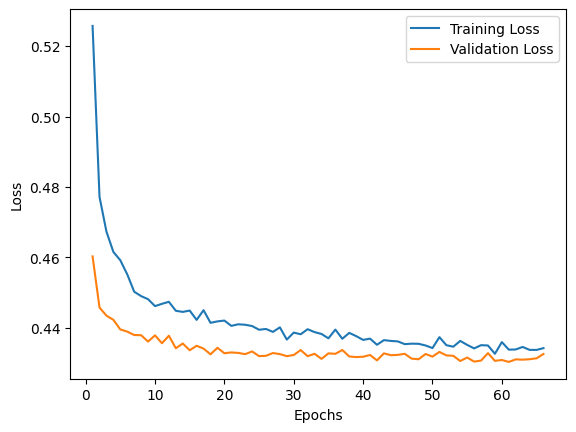

In [4]:
# Early stopping parameters
best_val_loss = np.inf
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in DataLoader(CustomDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False):
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    val_losses.append(val_loss / len(DataLoader(CustomDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'Validation loss did not improve, trigger times: {trigger_times}')
        if trigger_times >= patience:
            print('Early stopping')
            break

# Plot learning curves
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Hyperparameter Tuning

In [ ]:
# Define the SimpleNN Class
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

class SklearnNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.model = SimpleNN(self.input_dim, self.hidden1_dim, self.hidden2_dim, self.dropout_rate)

    def fit(self, X, y):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = CustomDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for epoch in range(50):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have shape [batch_size, 1]
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            predictions = (outputs > 0.5).float()
        return predictions.numpy().squeeze()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load the Credit Card Default dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Print unique values of the target variable in the original dataset
print("Unique values in the original target variable:", df['default_payment_next_month'].unique())

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns (if any)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Define the sklearn estimator wrapper
class SklearnNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.model = SimpleNN(self.input_dim, self.hidden1_dim, self.hidden2_dim, self.dropout_rate)

    def fit(self, X, y):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = CustomDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for epoch in range(50):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))  # Ensure targets have shape [batch_size, 1]
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            predictions = (outputs > 0.5).float()
        return predictions.numpy().squeeze()

# Define hyperparameter grid
param_grid = {
    'hidden1_dim': [32, 64, 128],
    'hidden2_dim': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001, 0.0001]
}

# Wrap the neural network in a scikit-learn estimator
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnNN(input_dim=input_dim)

# Perform grid search
grid_search = GridSearchCV(estimator=nn_estimator, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")



Unique values in the original target variable: [1 0]


## Sklearn & Pytorch

The creation of the `SimpleNN` class and the `SklearnNN` wrapper serves different purposes, and each is necessary for integrating PyTorch with scikit-learn.

### SimpleNN Class

The `SimpleNN` class defines the architecture of the neural network. This includes the layers, activation functions, and dropout layers. It is a typical PyTorch model class, and it doesn't interact with scikit-learn directly. Here, you specify the structure and forward pass of the neural network.

```python
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2_dim, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x
```

### SklearnNN Wrapper Class

The `SklearnNN` wrapper class is what allows us to use the `SimpleNN` class within the scikit-learn framework. It serves as an interface between scikit-learn and PyTorch, ensuring that scikit-learn can interact with the neural network model in a way it understands. The wrapper handles the training (`fit`) and prediction (`predict`) processes in a manner compatible with scikit-learn's expectations.

### Why Both Are Needed

1. **SimpleNN Class**:
   - Defines the neural network structure.
   - Implements the forward pass (how the data flows through the network).

2. **SklearnNN Wrapper Class**:
   - Acts as a bridge between scikit-learn and the PyTorch neural network.
   - Implements `fit` and `predict` methods, allowing the neural network to be used with scikit-learn tools like `GridSearchCV`.
   - Initializes an instance of `SimpleNN` internally to actually perform the training and predictions.

By separating these two components, we maintain a clear distinction between the neural network's definition and the logic needed to integrate it with scikit-learn. This modularity also makes the code easier to understand, maintain, and extend.

Combining the streamlined preprocessing efficiency of scikit-learn pipelines with the powerful neural networks of PyTorch can indeed be an ideal setup for many machine learning workflows. Here's a summary of why this combination is so powerful and some additional tips for making the most of it:

### Benefits of Combining scikit-learn and PyTorch

1. **Efficient Preprocessing**:
   - scikit-learn provides a wide array of tools for preprocessing data, such as imputation, scaling, encoding, and feature selection, which can be easily chained together using pipelines.
   - These preprocessing steps can be easily fit on training data and applied to test data, ensuring consistency and preventing data leakage.

2. **Powerful Neural Networks**:
   - PyTorch offers a highly flexible and powerful framework for building and training deep learning models.
   - PyTorch's dynamic computation graph allows for more complex model architectures and easier debugging.

3. **Hyperparameter Tuning and Model Selection**:
   - Using the scikit-learn API, you can leverage tools like `GridSearchCV` or `RandomizedSearchCV` for hyperparameter tuning.
   - Cross-validation and other model evaluation techniques can be easily applied.

4. **Consistent API**:
   - By wrapping PyTorch models in scikit-learn-compatible classes, you ensure a consistent and familiar interface for fitting, predicting, and evaluating models.

### Practical Tips

1. **Modularize Your Code**:
   - Keep the neural network architecture and the wrapper class separate. This makes the code more modular and easier to maintain.

2. **Use Pipelines for Preprocessing**:
   - Chain your preprocessing steps using scikit-learn pipelines. This ensures that all preprocessing is applied consistently across different stages of your workflow.

3. **Implement Early Stopping**:
   - Early stopping can prevent overfitting by monitoring validation loss during training and stopping when the model starts to overfit.

4. **Experiment with Different Architectures**:
   - Don’t hesitate to try different neural network architectures. Sometimes a more complex model can capture underlying patterns better, while other times a simpler model might generalize better.

5. **Monitor Performance Metrics**:
   - Use appropriate performance metrics for evaluation. Accuracy might not always be the best metric, especially for imbalanced datasets. Consider using precision, recall, F1-score, and ROC-AUC.

### Example Workflow

Here’s a streamlined example workflow combining scikit-learn preprocessing with a PyTorch neural network:



In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# PyTorch model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1_dim, hidden2_dim)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Sklearn estimator wrapper
class SklearnNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5, learning_rate=0.001):
        self.input_dim = input_dim
        self.hidden1_dim = hidden1_dim
        self.hidden2_dim = hidden2_dim
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.model = SimpleNN(self.input_dim, self.hidden1_dim, self.hidden2_dim, self.dropout_rate)

    def fit(self, X, y):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = CustomDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for epoch in range(50):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            predictions = (outputs > 0.5).float()
        return predictions.numpy().squeeze()

# Hyperparameter tuning
param_grid = {
    'hidden1_dim': [32, 64, 128],
    'hidden2_dim': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001, 0.0001]
}

input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnNN(input_dim=input_dim)

grid_search = GridSearchCV(estimator=nn_estimator, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test_tensor.numpy())
print(classification_report(y_test_tensor.numpy(), test_predictions))


This workflow is becoming increasingly common among practitioners who want to leverage the best features of both scikit-learn and PyTorch. Combining scikit-learn's efficient preprocessing and model evaluation tools with PyTorch's powerful neural network capabilities offers several advantages:

### Advantages of this Workflow

1. **Efficiency in Preprocessing**:
   - scikit-learn pipelines streamline the preprocessing steps, ensuring consistency and reducing the chances of data leakage.
   - With pipelines, you can easily transform and apply the same preprocessing steps to both training and test datasets.

2. **Powerful Neural Network Training**:
   - PyTorch provides a flexible and dynamic framework for building and training complex neural network models.
   - It supports dynamic computation graphs, which makes debugging and experimenting with different architectures easier.

3. **Hyperparameter Tuning and Model Selection**:
   - Using scikit-learn's `GridSearchCV` or `RandomizedSearchCV`, you can perform hyperparameter tuning to find the best parameters for your model.
   - Cross-validation ensures that the model generalizes well to unseen data.

4. **Consistent and Maintainable Code**:
   - Wrapping PyTorch models with scikit-learn's estimator interface makes the code more modular and maintainable.
   - It allows you to reuse existing scikit-learn tools and workflows without significant changes.

5. **Flexibility and Scalability**:
   - This approach allows you to scale your experiments easily and try different combinations of preprocessing techniques and model architectures.
   - It provides a clear separation of concerns, where preprocessing and model training are handled independently but integrated seamlessly.

### Real-World Use Cases

Many data science and machine learning teams use this workflow in various applications, such as:

- **Financial Services**: For credit scoring and fraud detection, where preprocessing of transactional data and complex model architectures are crucial.
- **Healthcare**: For predictive modeling and diagnostics, where preprocessing of medical records and training of deep learning models are required.
- **Retail**: For recommendation systems and customer segmentation, where preprocessing of purchase history and training of recommendation models are essential.

### Best Practices

Here are some best practices to follow when adopting this workflow:

1. **Modularize Your Code**:
   - Keep your code modular by separating preprocessing, model definition, and training logic.
   - Use classes and functions to encapsulate different parts of the workflow.

2. **Experiment and Iterate**:
   - Experiment with different preprocessing techniques, model architectures, and hyperparameters.
   - Use cross-validation to ensure that your model generalizes well to new data.

3. **Monitor Performance**:
   - Monitor various performance metrics, not just accuracy, to get a comprehensive understanding of your model's performance.
   - Use tools like TensorBoard or custom logging to track the training process.

4. **Version Control**:
   - Use version control systems like Git to track changes in your code and experiments.
   - Keep track of different versions of your models and preprocessing pipelines.

### Example Projects

- **Customer Churn Prediction**: Using customer interaction data, preprocess features with scikit-learn and train a neural network with PyTorch to predict customer churn.
- **Image Classification**: Use scikit-learn for initial data preprocessing (e.g., scaling, normalization) and PyTorch for training a convolutional neural network (CNN) for image classification.
- **Time Series Forecasting**: Preprocess time series data with scikit-learn and train a recurrent neural network (RNN) or transformer model with PyTorch for forecasting.

### Conclusion

This workflow is indeed a powerful and efficient way to combine the strengths of scikit-learn and PyTorch. It helps maintain clean and maintainable code while leveraging advanced machine learning and deep learning techniques. By following best practices and continuously experimenting, you can build robust models that perform well in real-world applications.

### Pytorch or Tensorflow

Combining scikit-learn pipelines with deep learning frameworks like PyTorch or TensorFlow is a common practice in the machine learning community. Both PyTorch and TensorFlow have their own ecosystems and advantages, and the choice between them often depends on factors such as personal preference, specific use cases, and organizational standards. Here's a comparison of how scikit-learn pipelines are commonly used with PyTorch and TensorFlow:

### PyTorch

1. **Dynamic Computation Graph**:
   - PyTorch is known for its dynamic computation graph, which allows for more flexible and intuitive model building and debugging.
   - This makes PyTorch particularly popular in research and experimentation settings.

2. **Integration with scikit-learn**:
   - PyTorch's flexibility makes it straightforward to integrate with scikit-learn pipelines.
   - You can wrap PyTorch models in scikit-learn-compatible classes, as shown in the previous example, to leverage scikit-learn's preprocessing, model selection, and evaluation tools.

3. **Popularity in Research**:
   - PyTorch is widely used in academic research due to its ease of use and the ability to quickly prototype models.
   - Many cutting-edge research papers and implementations are available in PyTorch.

### TensorFlow

1. **Static Computation Graph (TensorFlow 1.x) and Eager Execution (TensorFlow 2.x)**:
   - TensorFlow 1.x uses a static computation graph, which can be more efficient for production but less flexible for experimentation.
   - TensorFlow 2.x introduced eager execution, similar to PyTorch's dynamic graph, making it more user-friendly and flexible.

2. **Integration with scikit-learn**:
   - TensorFlow can also be integrated with scikit-learn pipelines, and TensorFlow 2.x makes this process more straightforward with Keras APIs.
   - Keras, which is now part of TensorFlow, provides a high-level API for building and training models, and it integrates well with scikit-learn's APIs.

3. **Production and Deployment**:
   - TensorFlow has strong support for production and deployment, with tools like TensorFlow Serving, TensorFlow Lite, and TensorFlow.js.
   - It is often preferred in industry settings where deployment and scalability are critical.

### Example: Combining scikit-learn with TensorFlow

Here's a brief example of how you might combine scikit-learn pipelines with a TensorFlow model using the Keras API:

```python
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Define the TensorFlow model
def create_model(hidden1_dim=64, hidden2_dim=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden1_dim, input_dim=X_train_processed.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=64, verbose=0)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden1_dim': [32, 64, 128],
    'hidden2_dim': [16, 32, 64],
    'dropout_rate': [0.3, 0.5, 0.7],
    'learning_rate': [0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test_processed)
print(classification_report(y_test, test_predictions))
```

### Summary

- Both PyTorch and TensorFlow are commonly used with scikit-learn pipelines.
- PyTorch is favored for its flexibility and ease of use, especially in research and experimentation.
- TensorFlow, especially with Keras, is popular for production and deployment due to its comprehensive ecosystem.
- The choice between PyTorch and TensorFlow often depends on specific project requirements, personal preference, and organizational standards.
- Combining scikit-learn with either framework provides a powerful and efficient workflow for building and training machine learning models.